In [1]:
import numpy as np
import pandas as pd

In [2]:
df = pd.read_csv(r"1.1-Output/ProcessedFeatures.csv")

In [3]:
df.head()

,Src Port,Dst Port,Protocol,Flow Duration,Total Fwd Packet,Total Bwd packets,Total Length of Fwd Packet,Total Length of Bwd Packet,Fwd Packet Length Max,Fwd Packet Length Min,...,Active Std,Active Max,Active Min,Idle Mean,Idle Std,Idle Max,Idle Min,ICMP Code,ICMP Type,Total TCP Flow Time
0,0,0,0,119719148,231,0,0,0,0,0,...,8.761761e+06,22509459,17,12685486.0,5.296658e+06,20694308,6499982,-1,-1,0
1,123,123,17,65511209,6,6,288,288,48,48,...,0.000000e+00,1506210,1506210,64004884.0,0.000000e+00,64004884,64004884,-1,-1,0
2,5353,5353,17,113976922,267,0,20447,0,153,37,...,5.491934e+06,10983883,14,25498178.0,1.883305e+07,48523116,5463561,-1,-1,0
3,123,123,17,67037196,8,8,384,384,48,48,...,0.000000e+00,11034681,11034681,55956316.0,0.000000e+00,55956316,55956316,-1,-1,0
4,123,123,17,68045057,8,8,384,384,48,48,...,0.000000e+00,11043596,11043596,56943904.0,0.000000e+00,56943904,56943904,-1,-1,0


In [4]:
low_card_continuous = [col for col in df.columns if df[col].nunique() < 10 and df[col].dtype != 'object']
print(low_card_continuous)

for col in df.columns:
    if df[col].nunique() < 10:
        print(f"CARDINALITY OF COLUMN [{col}]: {df[col].nunique()}")

print("\n")

for col in low_card_continuous:
    print(f"{col} (unique values: {df[col].nunique()}):")
    print(sorted(df[col].unique()))

del low_card_continuous

['Protocol', 'Fwd URG Flags', 'Bwd URG Flags', 'URG Flag Count', 'CWR Flag Count', 'ECE Flag Count', 'Subflow Fwd Packets', 'Subflow Bwd Packets', 'Fwd Seg Size Min', 'ICMP Code', 'ICMP Type']
CARDINALITY OF COLUMN [Protocol]: 4
CARDINALITY OF COLUMN [Fwd URG Flags]: 5
CARDINALITY OF COLUMN [Bwd URG Flags]: 2
CARDINALITY OF COLUMN [URG Flag Count]: 5
CARDINALITY OF COLUMN [CWR Flag Count]: 9
CARDINALITY OF COLUMN [ECE Flag Count]: 5
CARDINALITY OF COLUMN [Subflow Fwd Packets]: 2
CARDINALITY OF COLUMN [Subflow Bwd Packets]: 2
CARDINALITY OF COLUMN [Fwd Seg Size Min]: 9
CARDINALITY OF COLUMN [ICMP Code]: 6
CARDINALITY OF COLUMN [ICMP Type]: 5


Protocol (unique values: 4):
[0, 1, 6, 17]
Fwd URG Flags (unique values: 5):
[0, 2, 4, 8, 16]
Bwd URG Flags (unique values: 2):
[0, 2]
URG Flag Count (unique values: 5):
[0, 2, 4, 8, 16]
CWR Flag Count (unique values: 9):
[0, 1, 2, 3, 4, 6, 8, 9, 23]
ECE Flag Count (unique values: 5):
[0, 1, 2, 4, 14]
Subflow Fwd Packets (unique values: 2):
[0, 1]

In [5]:
df.drop(columns=['ICMP Code', 'ICMP Type', 'Src Port', 'Dst Port', 'Protocol', 'Fwd URG Flags', 'Bwd URG Flags', 'URG Flag Count'], inplace=True)

In [6]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
df_scaled = pd.DataFrame(scaler.fit_transform(df), columns=df.columns)

### CANOPY-BASED FEATURE SELECTION USING PEARSON'S CORRELATION

In [7]:
corr_matrix = df_scaled.corr().abs()
np.fill_diagonal(corr_matrix.values, 0)  # remove self-correlations

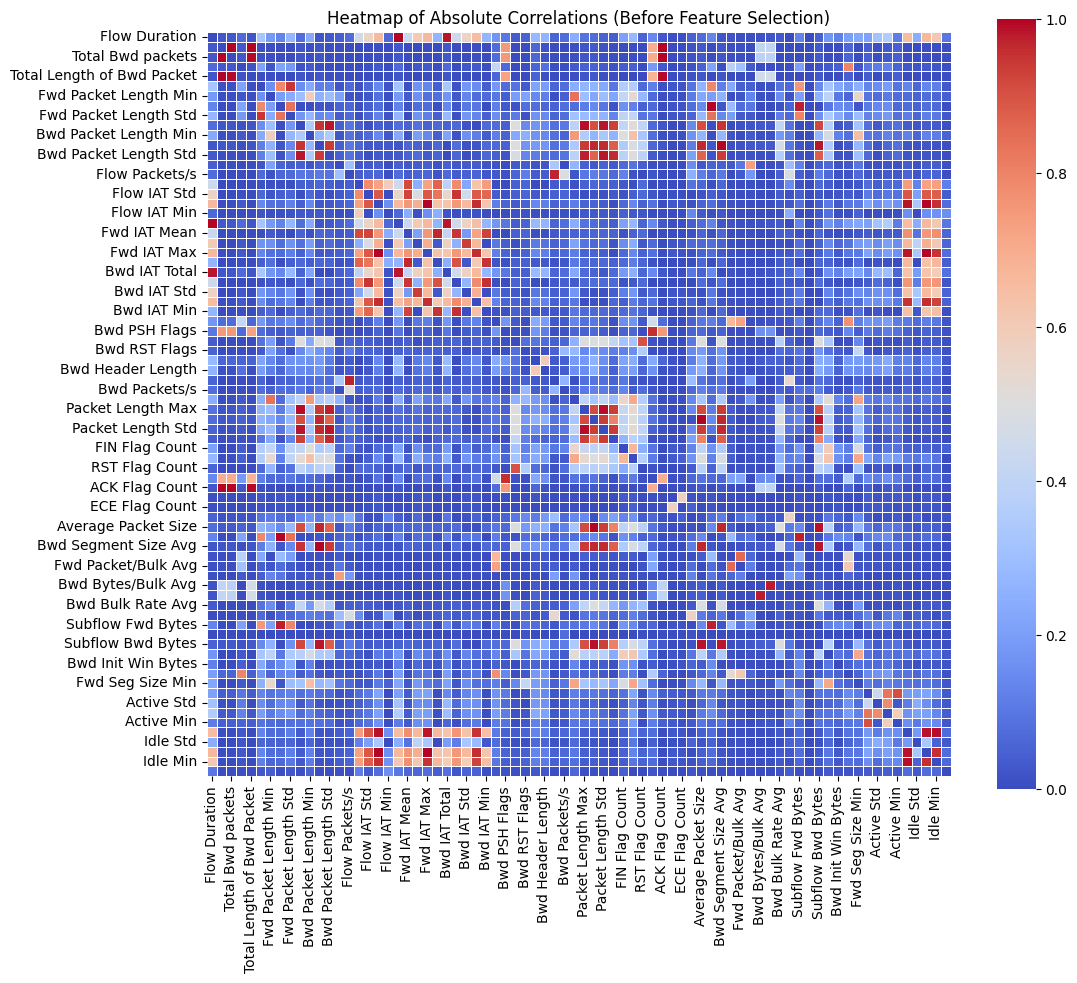

In [8]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(12, 10))
sns.heatmap(corr_matrix, cmap='coolwarm', square=True, linewidths=0.5)
plt.title("Heatmap of Absolute Correlations (Before Feature Selection)")
plt.show()

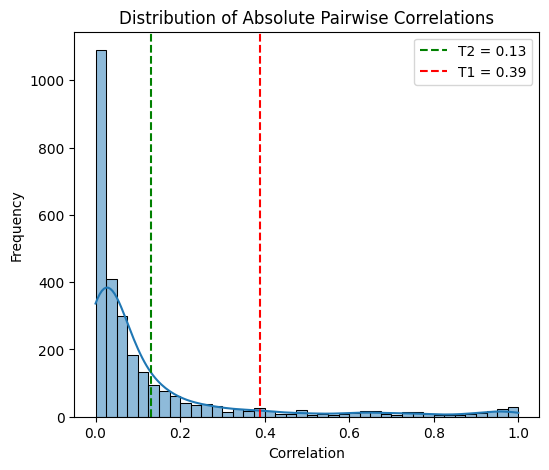

In [9]:
# Flatten upper triangle of correlation matrix (excluding self-correlation)
corr_values = corr_matrix.values[np.triu_indices_from(corr_matrix, k=1)]

# Compute thresholds based on percentiles
T1_pc = np.percentile(corr_values, 90)  # loose threshold
T2_pc = np.percentile(corr_values, 75)  # tight threshold

# Plot histogram
plt.figure(figsize=(6, 5))
sns.histplot(corr_values, bins=40, kde=True)
plt.axvline(T2_pc, color='green', linestyle='--', label=f'T2 = {T2_pc:.2f}')
plt.axvline(T1_pc, color='red', linestyle='--', label=f'T1 = {T1_pc:.2f}')
plt.title("Distribution of Absolute Pairwise Correlations")
plt.xlabel("Correlation")
plt.ylabel("Frequency")
plt.legend()
plt.show()

In [10]:
remaining_features_pc = set(corr_matrix.columns)
selected_features_pc = []
feature_canopies_pc = []

while remaining_features_pc:
    # Pick feature with highest average correlation to others
    sub_corr = corr_matrix.loc[list(remaining_features_pc), list(remaining_features_pc)]
    center = sub_corr.mean().idxmax()
    remaining_features_pc.remove(center)
    canopy = [center]

    for feature in list(remaining_features_pc):
        corr = corr_matrix.loc[center, feature]
        if corr <= T1_pc:                              # loosely related, include in canopy
            canopy.append(feature)
            if corr <= T2_pc:                          # tightly related, remove from consideration
                remaining_features_pc.remove(feature)

    selected_features_pc.append(center)
    feature_canopies_pc.append(canopy)

In [11]:
print(f"Selected {len(selected_features_pc)} features out of {df_scaled.shape[1]}")
print(f"Selected Features:\n", selected_features_pc)

Selected 15 features out of 76
Selected Features:
 ['Flow IAT Max', 'Fwd IAT Max', 'Idle Max', 'Idle Mean', 'Bwd IAT Max', 'Flow IAT Std', 'Idle Min', 'Bwd IAT Mean', 'Flow Duration', 'Fwd IAT Mean', 'Fwd IAT Total', 'Flow IAT Mean', 'Bwd IAT Total', 'Fwd IAT Min', 'Bwd IAT Min']


### CANOPY-BASED FEATURE SELECTION USING DISTANCE MEASURES

In [12]:
from dcor import distance_correlation
from joblib import Parallel, delayed
import multiprocessing

def compute_distance_correlation_matrix_fast(df, n_jobs=-1):
    features = df.columns
    n = len(features)
    dcorr_matrix = np.zeros((n, n))
    data = df.values.T  # Transpose for faster column access

    # Define computation per (i, j) pair
    def compute_entry(i, j):
        if i == j:
            return (i, j, 0.0)
        dc = distance_correlation(data[i], data[j])
        return (i, j, dc)

    # Create all (i, j) pairs for upper triangle
    pairs = [(i, j) for i in range(n) for j in range(i, n)]

    # Use joblib for parallel execution
    results = Parallel(n_jobs=n_jobs, backend='loky', verbose=1)(
        delayed(compute_entry)(i, j) for (i, j) in pairs
    )

    # Fill matrix
    for i, j, dc in results:
        dcorr_matrix[i, j] = dcorr_matrix[j, i] = dc

    return pd.DataFrame(dcorr_matrix, index=features, columns=features)


In [13]:
df_sampled = df_scaled.sample(n=200000, random_state=1)

dcorr_matrix = compute_distance_correlation_matrix_fast(df_sampled)

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:   48.2s
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:  1.1min
[Parallel(n_jobs=-1)]: Done 434 tasks      | elapsed:  1.6min
[Parallel(n_jobs=-1)]: Done 784 tasks      | elapsed:  2.2min
[Parallel(n_jobs=-1)]: Done 1234 tasks      | elapsed:  3.2min
[Parallel(n_jobs=-1)]: Done 1784 tasks      | elapsed:  4.6min
[Parallel(n_jobs=-1)]: Done 2434 tasks      | elapsed:  6.0min
[Parallel(n_jobs=-1)]: Done 2926 out of 2926 | elapsed:  7.1min finished


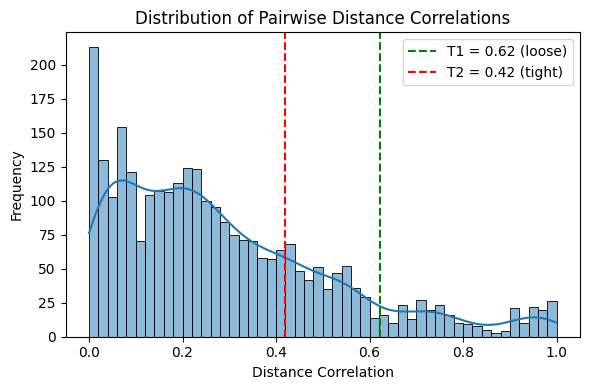

In [14]:
dcorr_vals = dcorr_matrix.values[np.triu_indices_from(dcorr_matrix, k=1)]

# Calculate dynamic thresholds based on percentiles
T1_dm = np.percentile(dcorr_vals, 90)  # Loose threshold
T2_dm = np.percentile(dcorr_vals, 75)  # Tight threshold

plt.figure(figsize=(6, 4))
sns.histplot(dcorr_vals, bins=50, kde=True)
plt.axvline(T1_dm, color='green', linestyle='--', label=f'T1 = {T1_dm:.2f} (loose)')
plt.axvline(T2_dm, color='red', linestyle='--', label=f'T2 = {T2_dm:.2f} (tight)')
plt.title("Distribution of Pairwise Distance Correlations")
plt.xlabel("Distance Correlation")
plt.ylabel("Frequency")
plt.legend()
plt.tight_layout()
plt.show()

In [15]:
remaining_features_dm = set(dcorr_matrix.columns)
selected_features_dm = []
feature_canopies_dm = []

while remaining_features_dm:
    sub_corr = dcorr_matrix.loc[list(remaining_features_dm), list(remaining_features_dm)]
    center = sub_corr.mean().idxmax()
    remaining_features_dm.remove(center)
    canopy = [center]

    for feature in list(remaining_features_dm):
        dep = dcorr_matrix.loc[center, feature]
        if dep <= T1_dm:  # loose threshold: include in canopy
            canopy.append(feature)
            if dep <= T2_dm:  # tight threshold: also remove from future selection
                remaining_features_dm.remove(feature)

    selected_features_dm.append(center)
    feature_canopies_dm.append(canopy)

In [16]:
print(f"Selected {len(selected_features_dm)} features out of {df_scaled.shape[1]}")
print(f"Selected Features:\n", selected_features_dm)

Selected 22 features out of 76
Selected Features:
 ['Fwd Header Length', 'Bwd Header Length', 'PSH Flag Count', 'Fwd PSH Flags', 'Packet Length Max', 'Packet Length Std', 'Bwd Packet Length Max', 'SYN Flag Count', 'Bwd Packet Length Std', 'Average Packet Size', 'Packet Length Min', 'Packet Length Mean', 'Fwd Packet Length Min', 'Fwd Packet Length Std', 'Subflow Bwd Bytes', 'Fwd Seg Size Min', 'FIN Flag Count', 'Bwd Segment Size Avg', 'FWD Init Win Bytes', 'Bwd Packet Length Min', 'Bwd Packet Length Mean', 'Bwd PSH Flags']


### CANOPY-BASED FEATURE SELECTION USING MUTUAL INFORMATION

In [17]:
from sklearn.metrics import mutual_info_score
from joblib import Parallel, delayed

def compute_mi_matrix_discretized_parallel(df, bins=10, n_jobs=-1):
    features = df.columns
    n = len(features)

    # ---------- Step 1: Vectorized Binning ----------
    binned_df = pd.DataFrame(index=df.index)

    for col in features:
        try:
            binned_df[col] = pd.qcut(df[col], q=bins, duplicates='drop')
        except:
            binned_df[col] = pd.cut(df[col], bins=bins)

    # Encode bins into integer labels
    binned_df = binned_df.apply(lambda col: col.cat.codes)

    # ---------- Step 2: Parallelized MI Computation ----------
    def compute_mi(i, j):
        if i == j:
            return (i, j, 0.0)
        mi = mutual_info_score(binned_df.iloc[:, i], binned_df.iloc[:, j])
        return (i, j, mi)

    # Generate all upper triangle index pairs
    index_pairs = [(i, j) for i in range(n) for j in range(i, n)]

    # Compute in parallel
    results = Parallel(n_jobs=n_jobs, backend='loky', verbose=1)(
        delayed(compute_mi)(i, j) for i, j in index_pairs
    )

    # Fill the MI matrix
    mi_matrix = np.zeros((n, n))
    for i, j, mi in results:
        mi_matrix[i, j] = mi_matrix[j, i] = mi

    return pd.DataFrame(mi_matrix, index=features, columns=features)

In [18]:
# Convert binary features to 'category'
df_MI = df
df_MI['Subflow Fwd Packets'] = df_MI['Subflow Fwd Packets'].astype('category')
df_MI['Subflow Bwd Packets'] = df_MI['Subflow Bwd Packets'].astype('category')

# Convert discrete protocol-size-like feature to 'category'
df_MI['Fwd Seg Size Min'] = df_MI['Fwd Seg Size Min'].astype('category')

In [19]:
# df_sampled = df_scaled.sample(n=2000000, random_state=1)
mi_matrix = compute_mi_matrix_discretized_parallel(df_MI)

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    7.6s
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:   33.1s
[Parallel(n_jobs=-1)]: Done 434 tasks      | elapsed:  1.2min
[Parallel(n_jobs=-1)]: Done 784 tasks      | elapsed:  2.2min
[Parallel(n_jobs=-1)]: Done 1234 tasks      | elapsed:  3.3min
[Parallel(n_jobs=-1)]: Done 1784 tasks      | elapsed:  4.6min
[Parallel(n_jobs=-1)]: Done 2434 tasks      | elapsed:  6.3min
[Parallel(n_jobs=-1)]: Done 2926 out of 2926 | elapsed:  7.6min finished


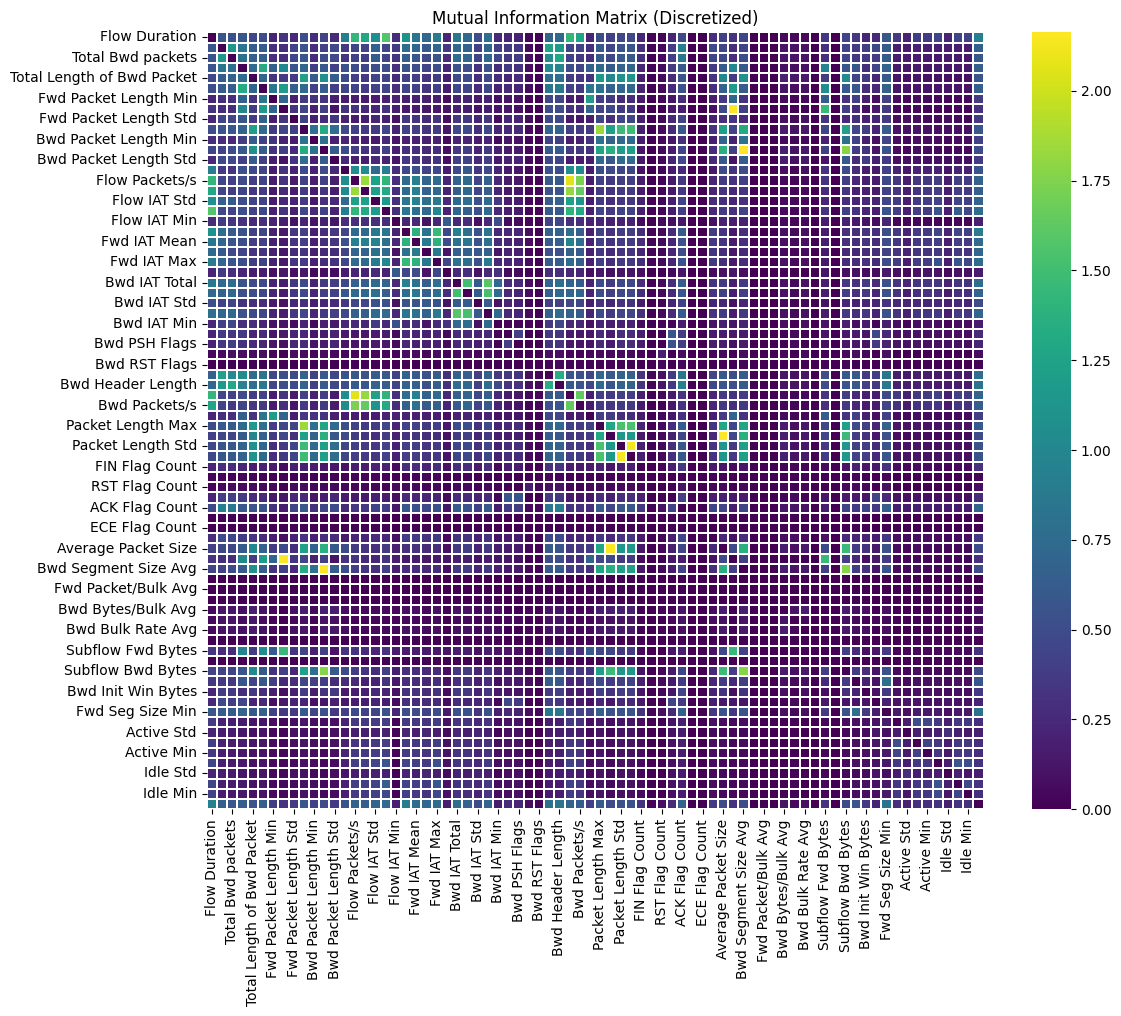

In [20]:
plt.figure(figsize=(12, 10))
sns.heatmap(mi_matrix, cmap="viridis", square=True, linewidths=0.2)
plt.title("Mutual Information Matrix (Discretized)")
plt.tight_layout()
plt.show()

In [21]:
mi_vals = mi_matrix.values[np.triu_indices_from(mi_matrix, k=1)]

# Use percentile thresholds
T1_mi = np.percentile(mi_vals, 90)  # loose threshold
T2_mi = np.percentile(mi_vals, 75)  # tight threshold

print(f"T1 (loose): {T1_mi:.4f}, T2 (tight): {T2_mi:.4f}")

T1 (loose): 0.6167, T2 (tight): 0.3735


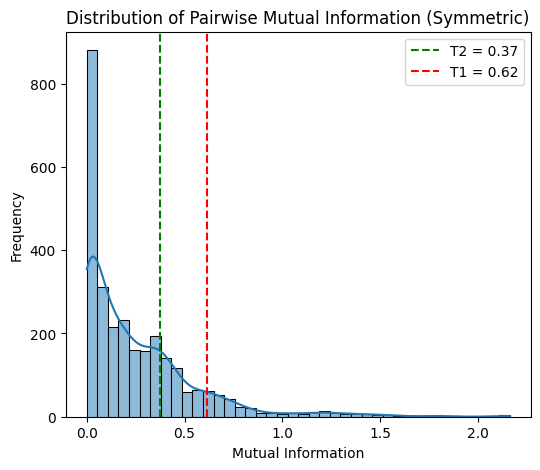

In [22]:
plt.figure(figsize=(6, 5))
sns.histplot(mi_vals, bins=40, kde=True)
plt.axvline(T2_mi, color='green', linestyle='--', label=f'T2 = {T2_mi:.2f}')
plt.axvline(T1_mi, color='red', linestyle='--', label=f'T1 = {T1_mi:.2f}')
plt.title("Distribution of Pairwise Mutual Information (Symmetric)")
plt.xlabel("Mutual Information")
plt.ylabel("Frequency")
plt.legend()
plt.show()

In [23]:
remaining_features_mi = set(mi_matrix.columns)
selected_features_mi = []
feature_canopies_mi = []

while remaining_features_mi:
    sub_mi = mi_matrix.loc[list(remaining_features_mi), list(remaining_features_mi)]
    center = sub_mi.mean().idxmax()
    remaining_features_mi.remove(center)
    canopy = [center]

    for feature in list(remaining_features_mi):
        mi_score = mi_matrix.loc[center, feature]
        if mi_score <= T1_mi:  # loose threshold: include in canopy
            canopy.append(feature)
            if mi_score <= T2_mi:  # tight threshold: exclude from future centers
                remaining_features_mi.remove(feature)

    selected_features_mi.append(center)
    feature_canopies_mi.append(canopy)

In [24]:
print(f"Selected {len(selected_features_mi)} features out of {df_scaled.shape[1]}")
print(f"Selected Features:\n", selected_features_mi)

Selected 22 features out of 76
Selected Features:
 ['Bwd Header Length', 'Packet Length Max', 'Bwd Packet Length Max', 'Packet Length Variance', 'Fwd Header Length', 'Bwd Packet Length Mean', 'Average Packet Size', 'Packet Length Std', 'Bwd Segment Size Avg', 'Total Length of Fwd Packet', 'Total Length of Bwd Packet', 'Total TCP Flow Time', 'Flow Duration', 'Total Fwd Packet', 'Packet Length Mean', 'Total Bwd packets', 'Fwd Seg Size Min', 'Fwd Packet Length Max', 'Bwd IAT Mean', 'Subflow Bwd Bytes', 'ACK Flag Count', 'Flow IAT Max']


### COMPARATIVE ANALYSIS

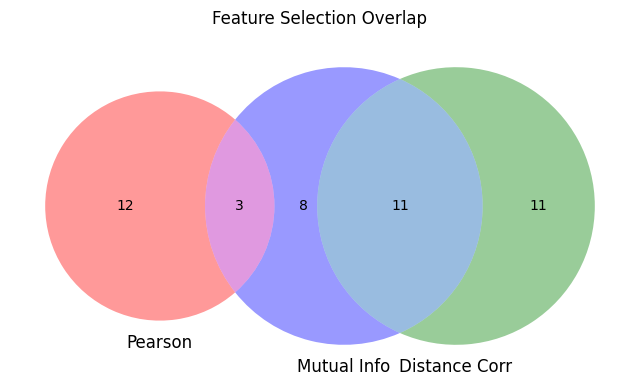

In [25]:
from matplotlib_venn import venn3
import matplotlib.pyplot as plt

# Assume these are your selected feature sets
pearson_features = set(selected_features_pc)
dcorr_features = set(selected_features_dm)
mi_features = set(selected_features_mi)

plt.figure(figsize=(8, 6))
venn3([pearson_features, dcorr_features, mi_features],
      set_labels=('Pearson', 'Distance Corr', 'Mutual Info'))

plt.title("Feature Selection Overlap")
plt.show()

In [26]:
print(f"PEARSON CORRELATION FEATURES ({len(selected_features_pc)}):\n{selected_features_pc}\n")
print(f"DISTANCE CORRELATION FEATURES ({len(selected_features_dm)}):\n{selected_features_dm}\n")
print(f"DISCRETIZED MUTUAL INFORMATION FEATURES ({len(selected_features_mi)}):\n{selected_features_mi}\n")

PEARSON CORRELATION FEATURES (15):
['Flow IAT Max', 'Fwd IAT Max', 'Idle Max', 'Idle Mean', 'Bwd IAT Max', 'Flow IAT Std', 'Idle Min', 'Bwd IAT Mean', 'Flow Duration', 'Fwd IAT Mean', 'Fwd IAT Total', 'Flow IAT Mean', 'Bwd IAT Total', 'Fwd IAT Min', 'Bwd IAT Min']

DISTANCE CORRELATION FEATURES (22):
['Fwd Header Length', 'Bwd Header Length', 'PSH Flag Count', 'Fwd PSH Flags', 'Packet Length Max', 'Packet Length Std', 'Bwd Packet Length Max', 'SYN Flag Count', 'Bwd Packet Length Std', 'Average Packet Size', 'Packet Length Min', 'Packet Length Mean', 'Fwd Packet Length Min', 'Fwd Packet Length Std', 'Subflow Bwd Bytes', 'Fwd Seg Size Min', 'FIN Flag Count', 'Bwd Segment Size Avg', 'FWD Init Win Bytes', 'Bwd Packet Length Min', 'Bwd Packet Length Mean', 'Bwd PSH Flags']

DISCRETIZED MUTUAL INFORMATION FEATURES (22):
['Bwd Header Length', 'Packet Length Max', 'Bwd Packet Length Max', 'Packet Length Variance', 'Fwd Header Length', 'Bwd Packet Length Mean', 'Average Packet Size', 'Packet Le

In [27]:
import pandas as pd
import numpy as np

# Replace these with your actual selected feature sets
pearson_features = set(pearson_features)
dcorr_features = set(dcorr_features)
mi_features = set(mi_features)

# Replace these with your full MI and Dcorr matrices (dataframes)
# These should contain all features in rows and columns
MI_matrix = mi_matrix
Dcorr_matrix = dcorr_matrix

# --- Pack feature sets into a dictionary ---
feature_sets = {
    'Pearson': pearson_features,
    'Dcorr': dcorr_features,
    'MI': mi_features
}

# --- Function to calculate average intra-set MI / Dcorr ---
def average_pairwise_score(feature_list, matrix):
    if len(feature_list) < 2:
        return 0.0
    submatrix = matrix.loc[feature_list, feature_list].copy()
    np.fill_diagonal(submatrix.values, np.nan)
    return np.nanmean(submatrix.values)

# --- Calculate overlap with other sets ---
summary_rows = []
methods = list(feature_sets.keys())

for method in methods:
    fset = feature_sets[method]
    overlap_count = sum(len(fset & feature_sets[other]) for other in methods if other != method)

    avg_mi = average_pairwise_score(list(fset), MI_matrix)
    avg_dcorr = average_pairwise_score(list(fset), Dcorr_matrix)

    summary_rows.append({
        'Method': method,
        '# Features': len(fset),
        'Overlap with Others': overlap_count,
        'Avg MI': round(avg_mi, 3),
        'Avg Dcorr': round(avg_dcorr, 3)
    })

# --- Final Summary Table ---
summary_df = pd.DataFrame(summary_rows)
print(summary_df)

    Method  # Features  Overlap with Others  Avg MI  Avg Dcorr
0  Pearson          15                    3   0.621      0.766
1    Dcorr          22                   11   0.476      0.645
2       MI          22                   14   0.763      0.485


In [31]:
# ---------------------------------------------------------------
# Optimized Distance Correlation Matrix Computation Function
# ---------------------------------------------------------------
def compute_distance_correlation_matrix_fast(df, n_jobs=-1):
    features = df.columns
    n = len(features)
    dcorr_matrix = np.zeros((n, n))
    data = df.values.T  # Transpose for faster access to columns

    def compute_entry(i, j):
        if i == j:
            return (i, j, 0.0)
        dc = distance_correlation(data[i], data[j])
        return (i, j, dc)

    pairs = [(i, j) for i in range(n) for j in range(i, n)]

    results = Parallel(n_jobs=n_jobs, backend='loky', verbose=1)(
        delayed(compute_entry)(i, j) for (i, j) in pairs
    )

    for i, j, dc in results:
        dcorr_matrix[i, j] = dcorr_matrix[j, i] = dc

    return pd.DataFrame(dcorr_matrix, index=features, columns=features)

# ---------------------------------------------------------------
# Assume the three feature lists and your main dataframe exist
# selected_features_pc, selected_features_dm, selected_features_mi
# df = your full dataframe of predicting features
# ---------------------------------------------------------------

df_sampled = df_scaled.sample(n=20000, random_state=1)

df_pc = df_sampled[selected_features_pc]
df_dm = df_sampled[selected_features_dm]
df_mi = df_sampled[selected_features_mi]

# Compute optimized Dcorr matrices
dcorr_pc = compute_distance_correlation_matrix_fast(df_pc, n_jobs=-1)
dcorr_dm = compute_distance_correlation_matrix_fast(df_dm, n_jobs=-1)
dcorr_mi = compute_distance_correlation_matrix_fast(df_mi, n_jobs=-1)

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed:    0.4s
[Parallel(n_jobs=-1)]: Done 105 out of 120 | elapsed:    0.6s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done 120 out of 120 | elapsed:    0.6s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed:    0.4s
[Parallel(n_jobs=-1)]: Done 253 out of 253 | elapsed:    1.4s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed:    0.4s
[Parallel(n_jobs=-1)]: Done 238 out of 253 | elapsed:    1.5s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done 253 out of 253 | elapsed:    1.6s finished


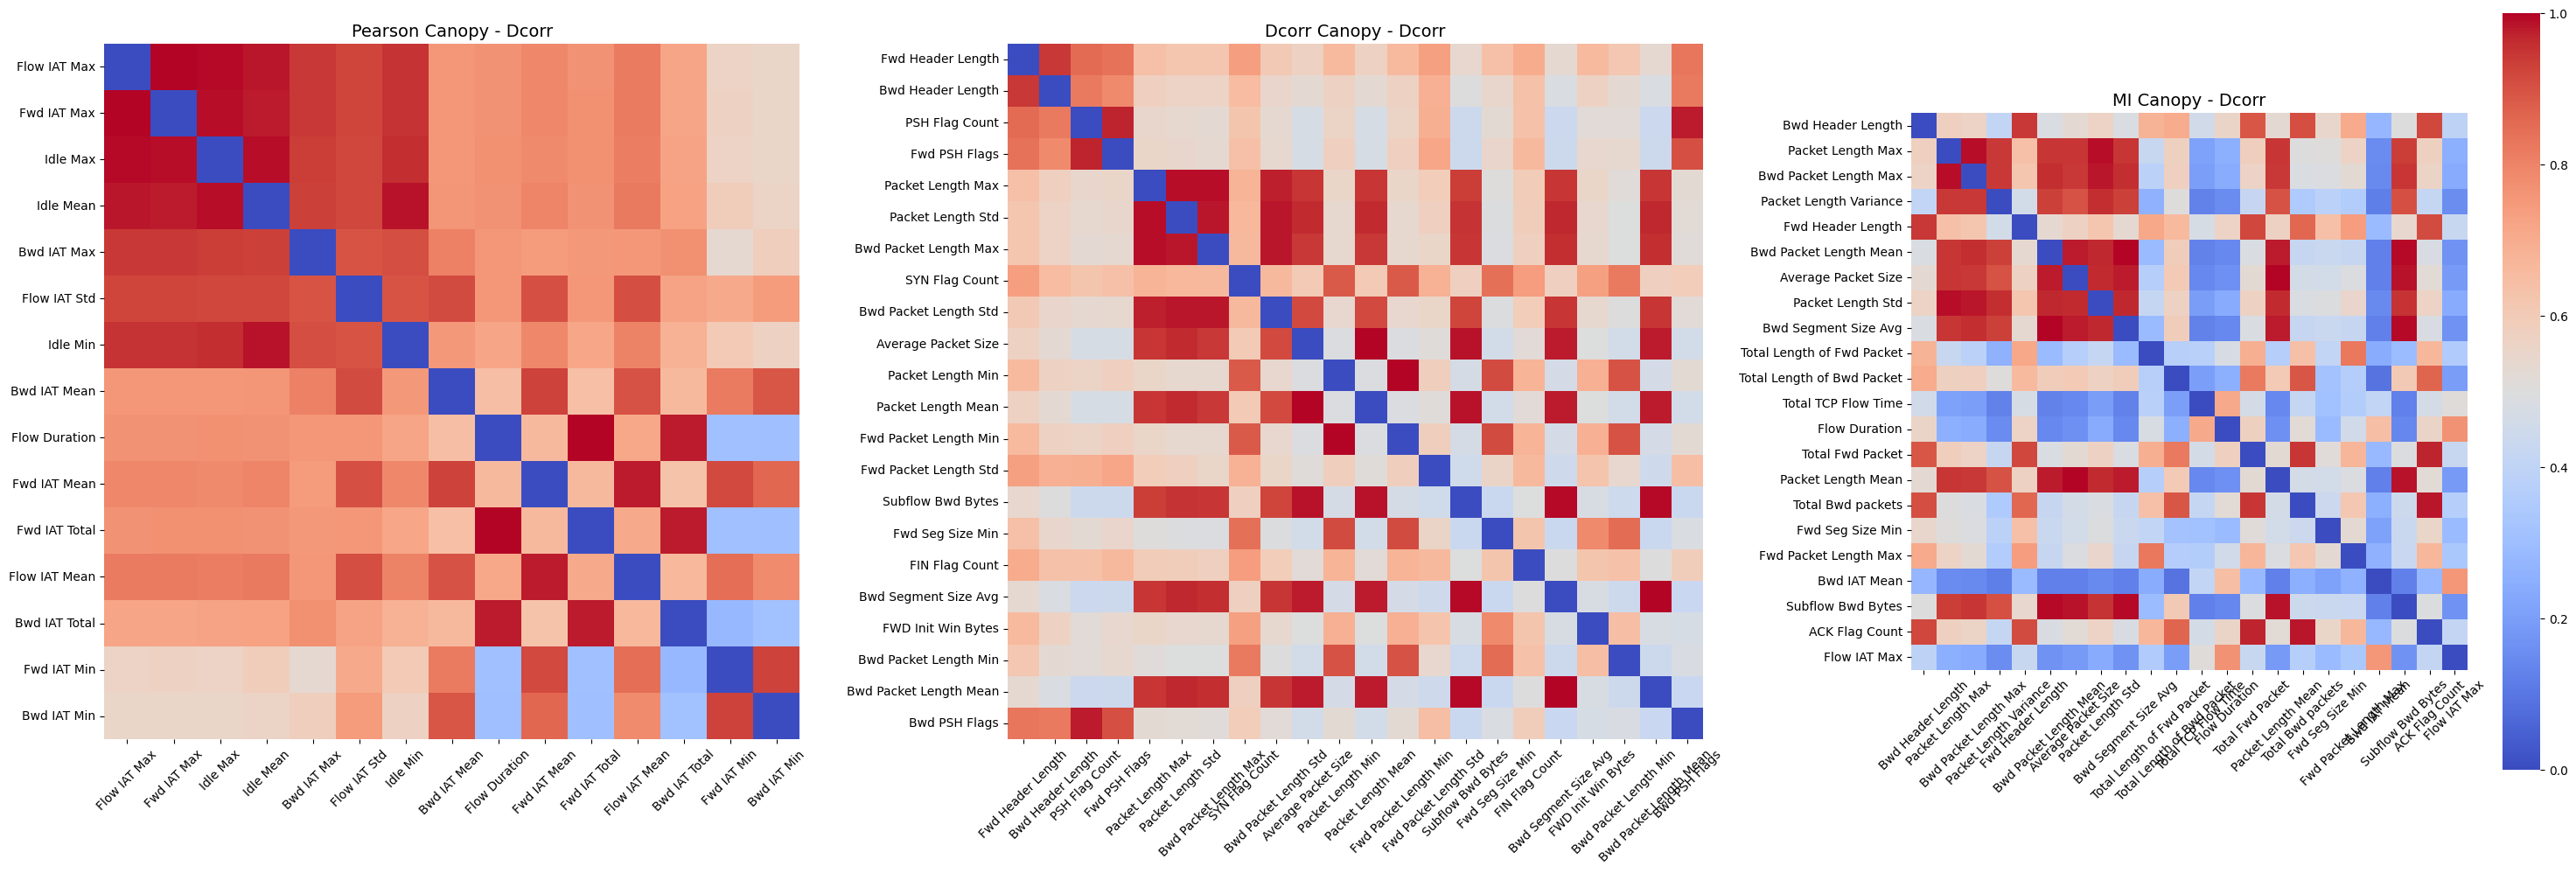

In [33]:
# ---------------------------------------------------------------
# Plotting the Heatmaps
# ---------------------------------------------------------------
fig, axes = plt.subplots(1, 3, figsize=(30, 10))

sns.heatmap(dcorr_pc, ax=axes[0], cmap="coolwarm", square=True, cbar=False)
axes[0].set_title("Pearson Canopy - Dcorr", fontsize=14)
axes[0].tick_params(axis='x', rotation=45)

sns.heatmap(dcorr_dm, ax=axes[1], cmap="coolwarm", square=True, cbar=False)
axes[1].set_title("Dcorr Canopy - Dcorr", fontsize=14)
axes[1].tick_params(axis='x', rotation=45)

sns.heatmap(dcorr_mi, ax=axes[2], cmap="coolwarm", square=True, cbar=True)
axes[2].set_title("MI Canopy - Dcorr", fontsize=14)
axes[2].tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.show()